# Estimating π

## Grid method

Estimated π: 3.119302029212822 (True π: 3.141592653589793)


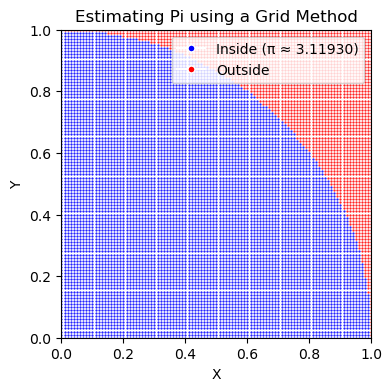

In [1]:
import numpy as np
import matplotlib.pyplot as plt

grid_size = 0.01  # Spacing between grid points - decrese this for better approximations
x = np.arange(0, 1 + grid_size, grid_size) # 1 + grid_size : to ensure endpoint 1 is included in the grid
y = np.arange(0, 1 + grid_size, grid_size)

# set counters points inside (and outside) the circle
in_circle = 0
out_of_circle = 0

plt.figure(figsize=(4, 4))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Estimating Pi using a Grid Method')
plt.xlim([0, 1])
plt.ylim([0, 1])

for xi in x:
    for yi in y:
        if xi**2 + yi**2 <= 1: # check if point is inside the circle
            plt.scatter(xi, yi, s=0.3, c='blue') # plot inside points
            in_circle += 1
        else:
            plt.scatter(xi, yi, s=0.3, c='red') # plot outside points
            out_of_circle += 1

# Estimate π
pi_estimate = 4 * (in_circle / (len(x) * len(y))) # approximation for (area of the circle/ area of the square)

print(f"Estimated π: {pi_estimate} (True π: {np.pi})")
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label=f'Inside (π ≈ {pi_estimate:.5f})', markersize=5, markerfacecolor='blue'),
    plt.Line2D([0], [0], marker='o', color='w', label='Outside', markersize=5, markerfacecolor='red')])
plt.show()

## Monte Carlo Sampling

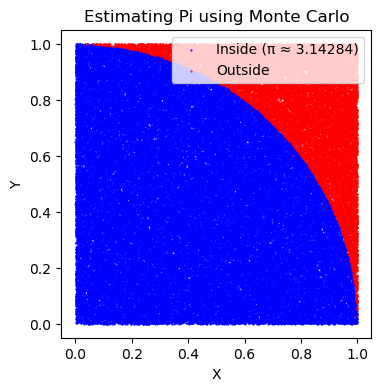

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 100000  # Number of random points - increase for better estimation
points = np.random.rand(n_samples, 2)  # Random (x, y) in the interval [0, 1)

in_circle = points[:, 0]**2 + points[:, 1]**2 <= 1 #check if points are inside the quarter circle
# in_circle is a boolean array - we check if at ith values xi^2 + yi^2 <= 1

pi_estimate = 4 * np.mean(in_circle) # calculates the fraction of True values (points inside).

plt.figure(figsize=(4, 4))
plt.scatter(points[in_circle, 0], points[in_circle, 1], s=0.3, c='blue', label=f'Inside (π ≈ {pi_estimate:.5f})')
plt.scatter(points[~in_circle, 0], points[~in_circle, 1], s=0.3, c='red', label='Outside')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Estimating Pi using Monte Carlo')
plt.legend()
plt.show()

## Metropolis-Hasting

### Binomial Likelihood 

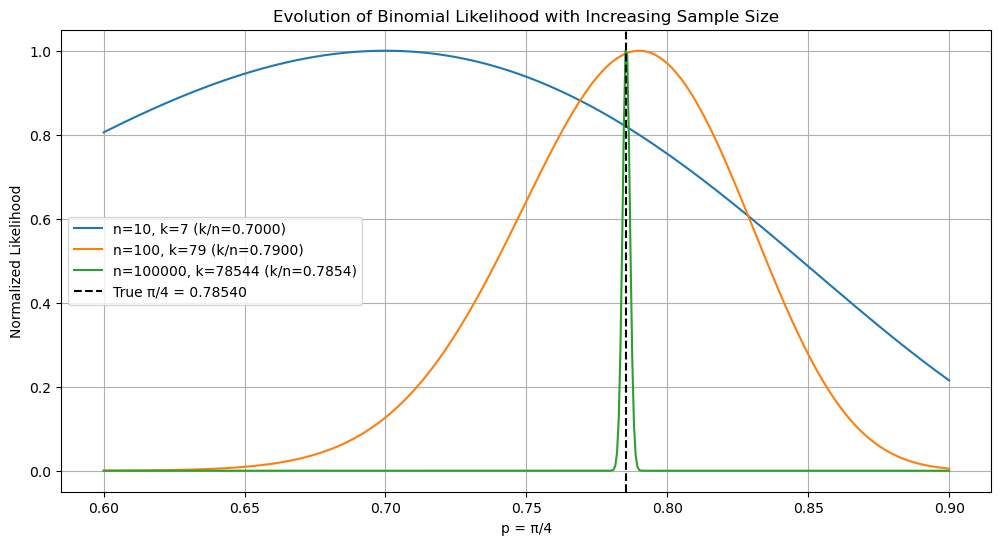

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln # we have some gamma functions 

def binomial_likelihood(p, n, k): #k successes out of n trials
    log_likelihood = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1) + \
                     k * np.log(p) + (n - k) * np.log(1 - p)
    return np.exp(log_likelihood)

# True value
true_p = np.pi/4

# Generate data for different n values - number of trails
n_values = [10, 100, 100000]
plt.figure(figsize=(12, 6))

for n in n_values:
    # Simulating data - same as we had before
    points = np.random.rand(n, 2)
    inside = (points[:, 0]**2 + points[:, 1]**2) <= 1
    k = np.sum(inside)
    
    # calculate likelihood across p values - proposal distribution (0.6, 0.9) - here I have taken uniform distribution
    p_values = np.linspace(0.6, 0.9, 500)
    likelihoods = [binomial_likelihood(p, n, k) for p in p_values]
    
    # normalize likelihood for better visualization
    likelihoods = likelihoods/np.max(likelihoods)
    
    plt.plot(p_values, likelihoods, label=f'n={n}, k={k} (k/n={k/n:.4f})')

plt.axvline(x=true_p, color='k', linestyle='--', label=f'True π/4 = {true_p:.5f}')
plt.xlabel('p = π/4')
plt.ylabel('Normalized Likelihood')
plt.title('Evolution of Binomial Likelihood with Increasing Sample Size')
plt.legend()
plt.grid(True)
plt.show()

### MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import beta

#just the binomial coefficient: log(n choose k)
def log_binomial_coef(n, k): 
    return gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)

#The same Log-likelihood of observing k successes in n trials given success prob p
def log_likelihood(p, n, k): 
    if p <= 0 or p >= 1:
        return -np.inf  # log(0) is -infinity if p is out of bounds
    return log_binomial_coef(n, k) + k*np.log(p) + (n-k)*np.log(1-p)

In [13]:
# Metropolis–Hastings sampler for p
def metropolis_hastings(num_samples, n, k, p_init=0.75, proposal_std=0.002): #keep proposal_std less so that you dont exclude important proposals
    samples = [] # we will append this as we go along the chain
    accepted = 0
    p = p_init # set to 0.75 as the initial guess (step 1)

    for i in range(num_samples):
        p_proposed = np.random.normal(p, proposal_std) # propose new p from Gaussian around current (step 2)
        if p_proposed <= 0 or p_proposed >= 1: #enforce p is in (0,1)
            samples.append(p)  # reject immediately
            continue
        
        # compute acceptance probability
        log_lik_current = log_likelihood(p, n, k)
        log_lik_proposed = log_likelihood(p_proposed, n, k)
        log_accept_ratio = log_lik_proposed - log_lik_current # (step 3)
        
        if np.log(np.random.rand()) < log_accept_ratio: # u< r (step 4)
            p = p_proposed
            accepted += 1
        samples.append(p)

    return np.array(samples), accepted / num_samples # the second output is essentially the acc_rate = total accepted proposals/total number of proposals

In [14]:
# simulate data - again same thing
np.random.seed(42)
num_points = 10**6
points = np.random.rand(num_points, 2)
inside = (points[:,0]**2 + points[:,1]**2) <= 1
k = np.sum(inside)

# run MH to get samples and also acceptance rate
samples, acc_rate = metropolis_hastings(10000, n=num_points, k=k) # here, acc_rate is the acceptance rate
print(f"Acceptance rate: {acc_rate:.2f}")
print(f"Estimated π: {4*np.mean(samples):.5f}")

Acceptance rate: 0.24
Estimated π: 3.14122


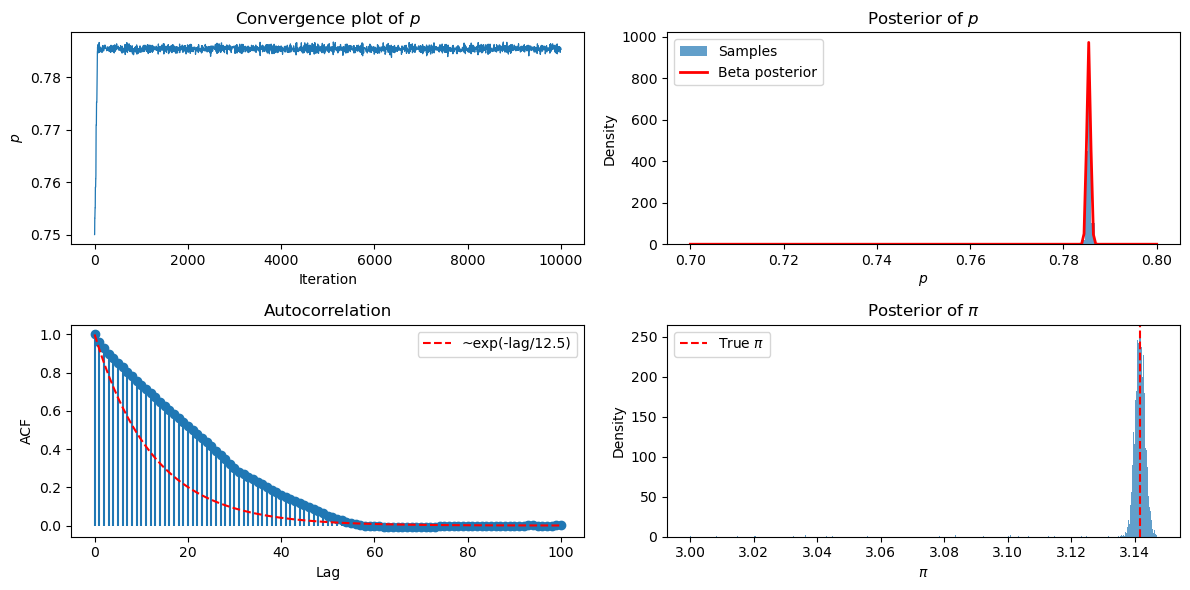

In [16]:
# Let us plot and see whats going on here 

from statsmodels.tsa.stattools import acf

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
####################################
# Convergence plot
axs[0,0].plot(samples, lw=0.9)
axs[0,0].set_title(r"Convergence plot of $p$")
axs[0,0].set_xlabel("Iteration")
axs[0,0].set_ylabel(r"$p$")
##############################################
# Histogram of samples - Posterior distribution of p
axs[0,1].hist(samples, bins=50, density=True, alpha=0.7, label='Samples')
axs[0,1].set_title(r"Posterior of $p$")
axs[0,1].set_xlabel(r"$p$")
axs[0,1].set_ylabel("Density")

# Compare with exact Beta posterior
alpha_post = k+1
beta_post = num_points-k+1 #(n-k+1)
p_vals = np.linspace(0.7, 0.8, 200)
axs[0,1].plot(p_vals, beta.pdf(p_vals, alpha_post, beta_post), 'r-', lw=2, label='Beta posterior')
axs[0,1].legend()
############################
# Autocorrelation
# first we prepare the exponential fit
#acf computes the autocorrelation at lags 0,1,…,nlags for your samples. fft=True speeds it up using Fourier transforms.
#acf_vals[lag] ρ(lag).
nlags = 100
acf_vals = acf(samples, nlags=nlags, fft=True)  # Compute ACF
lags = np.arange(len(acf_vals))

# Fit exponential decay to ACF (measures MCMC efficiency)
log_acf = np.log(np.abs(acf_vals[acf_vals > 0]))  # Avoid log(0)
## naive exponential fit (just fit log) - linear solpe -1/tau

tau_guess = -1 / np.polyfit(lags[acf_vals > 0], log_acf, 1)[0]  # Slope ≈ -1/τ
#Fit a straight line to logρ(lag) vs lag, with slope = −1/τ, where τ is estimated as −1/slope

exp_fit = np.exp(-lags / tau_guess)  # Exponential fit curve
#Reconstruct an exponential curve using estimated τ → this is just to visualize how well the exponential fits the actual ACF.

########################################

# Compute ACF
from statsmodels.tsa.stattools import acf
acf_vals = acf(samples, nlags=100, fft=True)
axs[1,0].stem(range(len(acf_vals)), acf_vals, basefmt=' ')
axs[1,0].plot(lags, exp_fit, 'r--', label=f"~exp(-lag/{tau_guess:.1f})")
axs[1,0].set_title("Autocorrelation")
axs[1,0].set_xlabel("Lag")
axs[1,0].set_ylabel("ACF")
axs[1,0].legend()
##############################################

# π estimate
axs[1,1].hist(4*samples, bins=500, density=True, alpha=0.7)
axs[1,1].axvline(np.pi, color='r', linestyle='--', label=r"True $\pi$")
axs[1,1].set_title(r"Posterior of $\pi$")
axs[1,1].set_xlabel(r"$\pi$")
axs[1,1].set_ylabel("Density")
axs[1,1].legend()

plt.tight_layout()
plt.show()


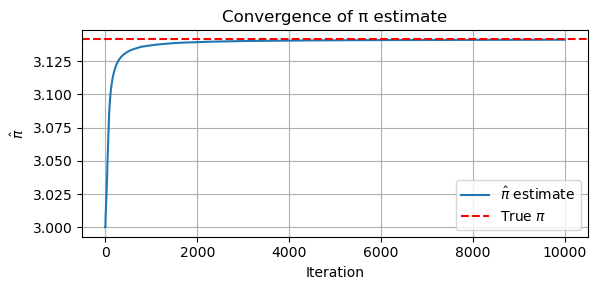

In [17]:
# Convergence plot of running mean estimate of π
running_mean = 4 * np.cumsum(samples) / np.arange(1, len(samples)+1)

plt.figure(figsize=(6,3))
plt.plot(running_mean, label=r'$\hat{\pi}$ estimate')
plt.axhline(np.pi, color='red', linestyle='--', label=r'True $\pi$')
plt.xlabel('Iteration')
plt.ylabel(r'$\hat{\pi}$')
plt.title('Convergence of π estimate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# H0 using supernova

## Chi squareed fit

  Supernova  V[km/s]  D[Mpc]  dD[Mpc]
0   SN1990O     9065   134.7     10.4
1   SN1190T    12012   158.9     14.9
2  SN1990af    15055   198.6     20.3
3   SN1991S    16687   238.9     19.8
4   SN1991U     9801   117.1     13.4


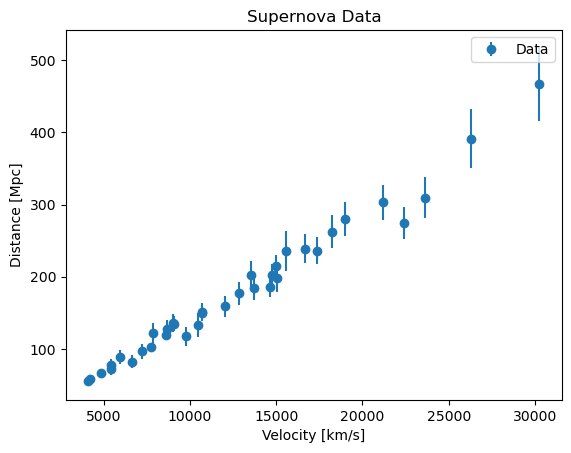

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\PÓS-DOC-01\Downloads\GRASP\supernova_data.csv")

# Look at the data
# print(df.head())

v_data = pd.to_numeric(df.iloc[:,1], errors='coerce').values # v (velocity)
d_obs  = pd.to_numeric(df.iloc[:,2], errors='coerce').values #  observed distance
d_err  = pd.to_numeric(df.iloc[:,3], errors='coerce').values #  error in observed distance

# Plot the data with error bars
plt.errorbar(v_data, d_obs, yerr=d_err, fmt='o', label='Data')
plt.xlabel("Velocity [km/s]")
plt.ylabel("Distance [Mpc]")
plt.title("Supernova Data")
plt.legend()
plt.show()


In [19]:
# theoretical model - simple first-order Hubble–Lemaître law
def dist_theory(v, h0, beta):
    return v / h0 + beta

# chi^2
def chi2(h0, beta, v_data, d_obs, d_err):
    theory = dist_theory(v_data, h0, beta)
    chi2_val = np.sum( ((d_obs - theory)/d_err)**2 )
    return chi2_val


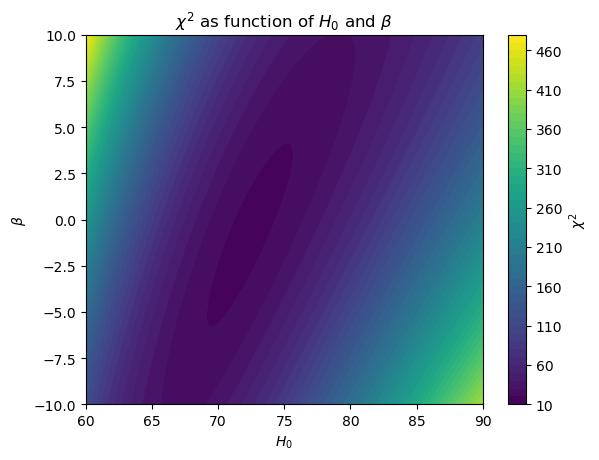

In [20]:
# set the priors
h0_vals = np.linspace(60, 90, 200)
beta_vals = np.linspace(-10, 10, 200)

H0, BETA = np.meshgrid(h0_vals, beta_vals)
CHI2 = np.zeros_like(H0)

for i in range(H0.shape[0]):
    for j in range(H0.shape[1]):
        CHI2[i,j] = chi2(H0[i,j], BETA[i,j], v_data, d_obs, d_err)

plt.contourf(H0, BETA, CHI2, levels=50, cmap='viridis')
plt.colorbar(label=r"$\chi^2$")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\beta$")
plt.title(r"$\chi^2$ as function of $H_0$ and $\beta$")
plt.show()


In [21]:
from scipy.optimize import minimize

result = minimize(lambda x: chi2(x[0], x[1], v_data, d_obs, d_err), x0=[70, 0])
best_h0, best_beta = result.x
print(f"Best-fit H0 = {best_h0:.2f}, Best-fit beta = {best_beta:.2f}")

# we are just looking for the derivative to vansih - this will give the best fit values

Best-fit H0 = 72.26, Best-fit beta = -0.84


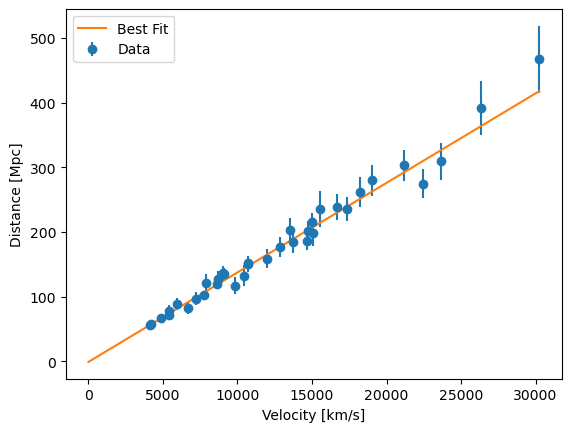

In [22]:
plt.errorbar(v_data, d_obs, yerr=d_err, fmt='o', label='Data')
v_fit = np.linspace(0, max(v_data), 100)
plt.plot(v_fit, dist_theory(v_fit, best_h0, best_beta), label='Best Fit')
plt.xlabel("Velocity [km/s]")
plt.ylabel("Distance [Mpc]")
plt.legend()
plt.show()


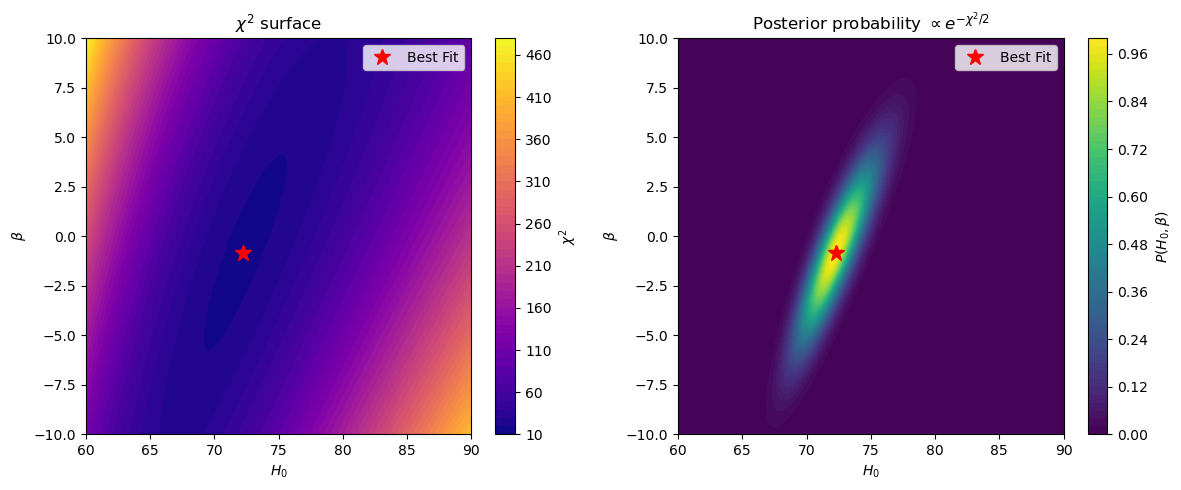

In [23]:
# already computed: H0, BETA, CHI2 from previous step

import matplotlib.ticker as ticker

# probability (unnormalized posterior)
prob_density = np.exp(-0.5 * (CHI2 - np.min(CHI2)))  # subtract min chi2 to avoid underflow

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# chi2 heatmap
c1 = axs[0].contourf(H0, BETA, CHI2, levels=50, cmap='plasma')
plt.colorbar(c1, ax=axs[0], label=r"$\chi^2$")
axs[0].set_xlabel(r"$H_0$")
axs[0].set_ylabel(r"$\beta$")
axs[0].set_title(r"$\chi^2$ surface")

axs[0].plot(best_h0, best_beta, 'r*', markersize=12, label='Best Fit')
axs[1].plot(best_h0, best_beta, 'r*', markersize=12, label='Best Fit')
axs[0].legend()
axs[1].legend()


# probability heatmap
c2 = axs[1].contourf(H0, BETA, prob_density, levels=50, cmap='viridis')
plt.colorbar(c2, ax=axs[1], label=r"$P(H_0, \beta)$")
axs[1].set_xlabel(r"$H_0$")
axs[1].set_ylabel(r"$\beta$")
axs[1].set_title(r"Posterior probability $\propto e^{-\chi^2/2}$")

plt.tight_layout()
plt.show()


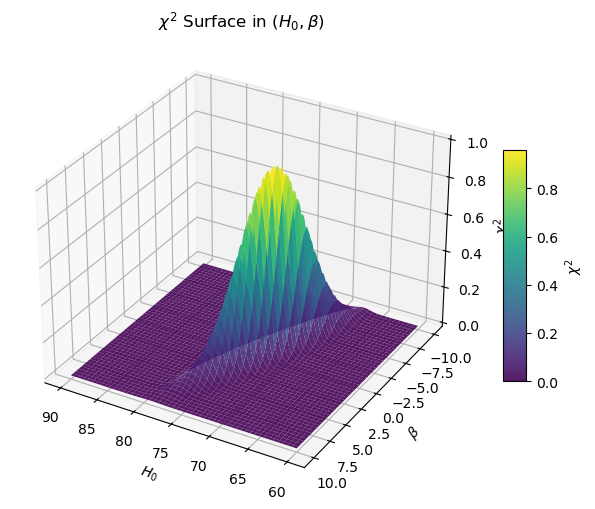

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# choose what to plot: CHI2 or prob_density
Z =  prob_density #CHI2  # or use: prob_density

# 3D surface
surf = ax.plot_surface(H0, BETA, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# labels and view
ax.set_xlabel(r"$H_0$")
ax.set_ylabel(r"$\beta$")
ax.set_zlabel(r"$\chi^2$")
ax.set_title(r"$\chi^2$ Surface in $(H_0, \beta)$")
fig.colorbar(surf, shrink=0.5, aspect=10, label=r"$\chi^2$")

# optionally adjust the view angle
ax.view_init(elev=30, azim=120)

plt.show()


### H0 from MCMC

In [25]:
import numpy as np
import pandas as pd

# Load your data
data = pd.read_csv(r"C:\Users\PÓS-DOC-01\Downloads\GRASP\supernova_data.csv")
v_data = pd.to_numeric(df.iloc[:,1], errors='coerce').values
d_data = pd.to_numeric(df.iloc[:,2], errors='coerce').values
sigma_data = pd.to_numeric(df.iloc[:,3], errors='coerce').values

def dist_theory(v, H0, beta):
    return v / H0 + beta

def chi2(H0, beta):
    model = dist_theory(v_data, H0, beta)
    return np.sum(((d_data - model) / sigma_data)**2)

def log_posterior(params):
    H0, beta = params
    # impose priors: both > 0
    if H0 <= 0:
        return -np.inf
    return -0.5 * chi2(H0, beta)


In [26]:
pip install emcee

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


In [28]:
import emcee

ndim = 2   # H0 and beta
nwalkers = 5
initial = np.array([70, 0])  # some reasonable starting guess
spread = [30, 30]

# Initialize walkers in a small ball around initial guess
p0 = initial + spread * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC...")
sampler.run_mcmc(p0, 5000, progress=True)

samples = sampler.get_chain(discard=1000, flat=True)


Running MCMC...


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1963.34it/s]


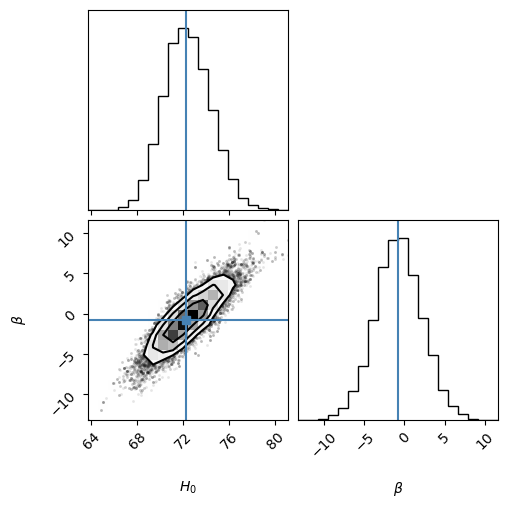

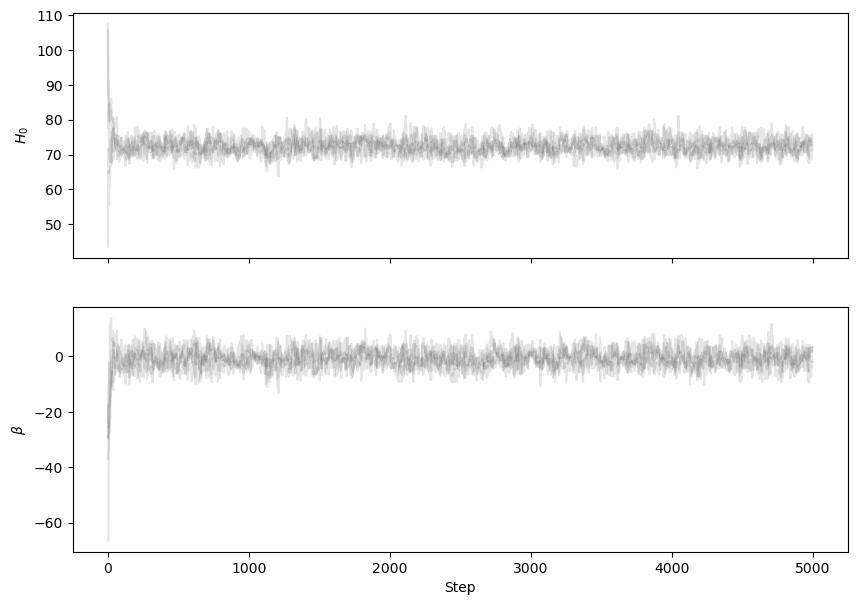

In [29]:
import corner

fig = corner.corner(samples, labels=["$H_0$", r"$\beta$"], truths=[best_h0, best_beta])
plt.show()

# Plot traces
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
axes[0].plot(sampler.get_chain()[:, :, 0], "k", alpha=0.1)
axes[0].set_ylabel("$H_0$")
axes[1].plot(sampler.get_chain()[:, :, 1], "k", alpha=0.1)
axes[1].set_ylabel(r"$\beta$")
axes[1].set_xlabel("Step")
plt.show()
